In [102]:
import torch

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [104]:
device

'cuda'

# Get data

In [105]:
from torchtext.datasets import SQuAD1

In [109]:
train, test = SQuAD1("root")

FileNotFoundError: [Errno 2] No such file or directory: 'root'

In [6]:
from modules.data import get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nebelgrau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nebelgrau/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nebelgrau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df = sample_df_perc(train_df, 0.2)

In [9]:
test_df = sample_df_perc(test_df, 0.2)

In [10]:
train_df.shape, test_df.shape

((17519, 2), (2114, 2))

In [11]:
train_df.head()

,Question,Answer
0,What events ended the war with Japan?,atomic bombings of Hiroshima and Nagasaki
1,What part of the United Kingdom is Belfast loc...,Northern Ireland
2,Where are the majority of Bermuda's hotels?,south shore of the island
3,What traits show a shared ancestry?,derived characters
4,What political party did not have trust in sta...,republican


In [12]:
import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What is another term for Greek?
['what', 'another', 'term', 'greek']
['what', 'anoth', 'term', 'greek']


# Vocabulary

In [13]:
from modules.vocab import Vocab

## Make pairs to add to the vocabularies. 

#### Only the questions will be normalized (stemmed) but not the answers - otherwise we would get stemmed words in the chatbot answers

In [14]:
for col, norm in zip(cols, ['stem', None]):
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [15]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [16]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
992,What are Egypt's 2 most prominent multinationa...,Orascom Group and Raya Contact Center,"[what, egypt, 2, promin, multin, compnai]","[orascom, group, raya, contact, center]"
1974,"In the Orthodox church, what types of icons ar...","flat, two-dimensional icons","[orthodox, church, what, type, icon, allow, ve...","[flat, twodimensional, icons]"
10662,What move did the Federal Reserve take that re...,increase the money supply,"[what, move, feder, reserv, take, result, stag...","[increase, money, supply]"


In [17]:
test_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
847,What do radical Islamist organizations reject ...,democracy,"[what, radic, islamist, organ, reject, entir]",[democracy]
1865,There is a public database of epitopes for pat...,B cells,"[public, databas, epitop, pathogen, known, rec...","[b, cells]"
104,The Rhine Gorge is between Koblenz and what ot...,Rüdesheim am Rhein,"[rhine, gorg, koblenz, what, citi]","[rüdesheim, rhein]"


In [18]:
cols_tokens = [f'{col}_tokens' for col in cols]

In [19]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [20]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [21]:
Q_vocab, A_vocab = Vocab(), Vocab()

In [22]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [23]:
Q_vocab.n_words, A_vocab.n_words, 

(13016, 16087)

In [24]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [25]:
Q_vocab.n_words, A_vocab.n_words 

(13935, 17289)

## Functions for some data analysis

In [26]:
from modules.stats import sentences_stats, histograms

In [27]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.43
	         median: 6.00
	         minimum: 1
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [28]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.50
	         median: 6.00
	         minimum: 2
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.35
	         median: 2.00
	         minimum: 0
	         maximum: 18)


## Remove the least common words from the sentences

In [29]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [30]:
get_outliers(Q_vocab, outlier_threshold+1), get_outliers(A_vocab, outlier_threshold+1)

(['belfast',
  'tuo',
  'rhode',
  'traceri',
  'melvill',
  'herskovit',
  'treason',
  'padma',
  'vibhushan',
  'sreedharan',
  'acclaim',
  '0159599',
  'palladium',
  '19161918',
  'fissil',
  'chari',
  'sil',
  'ataraxia',
  'gallon',
  'oltenia',
  'synchron',
  'fuji',
  'ppna',
  'perjor',
  'zeus',
  'asclepius',
  'bolt',
  '10217',
  'builder',
  'labyrinth',
  'magician',
  'sunk',
  'abhidhamma',
  'bombgrad',
  'plutonium',
  'labl',
  'caution',
  'disrespect',
  'impud',
  'sleepwak',
  'varactor',
  'varicap',
  'i94',
  'anc',
  'min',
  'djs',
  'wyatt',
  'paleontolog',
  '1790s',
  'hojo',
  'shigetoki',
  'scarciti',
  'cirqu',
  'nonchurch',
  'broader',
  'stall',
  'repeal',
  'esperienza',
  'ecclesiast',
  'cruiser',
  'battlecruis',
  'effic',
  'groom',
  'stain',
  'hanoi',
  'cater',
  'tamyra',
  'freshmen',
  'brahmi',
  'choral',
  'banu',
  'qurayza',
  'tabari',
  'grandchild',
  'alexandra',
  'timur',
  'codelist',
  'nowher',
  '04',
  '1579',
 

In [31]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [32]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [33]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.06
	         median: 6.00
	         minimum: 1
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 1.87
	         median: 1.00
	         minimum: 0
	         maximum: 19)


# remove questions that have less than three words and answers that have less than 1


## Remove long outliers: long sentences that occure rarely

In [35]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


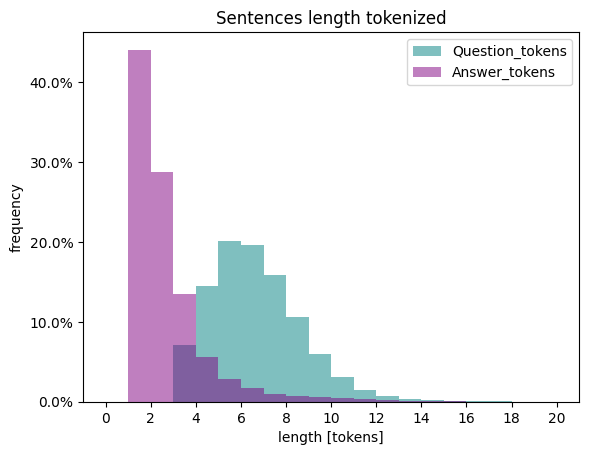

In [36]:
train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [37]:
train_df_final.shape

(14461, 4)

In [38]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.16
	         median: 6.00
	         minimum: 3
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 2.21
	         median: 2.00
	         minimum: 1
	         maximum: 19)


In [39]:
# keeping only the 95% of the data

cutoff = 95

In [41]:
# keeping only the 95% of the data

get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [42]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [43]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [44]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.98
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.96
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [45]:
train_df_final.shape

(13509, 4)

# Must make pairs from the dataset with removed short and long sequences

In [19]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [20]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

# building the model

In [46]:
from modules.models import Seq2Seq

In [47]:
hidden_size = 256

In [48]:
embedding_dim = 256

In [49]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words)

In [50]:
seq2seq = seq2seq.to(device)

In [51]:
from torch import optim
import torch.nn as nn

In [52]:
learning_rate = 0.001
num_epochs = 5

In [53]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device)

In [54]:
def train(model, pairs, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    
    total_loss = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    

    return total_loss / len(pairs)

In [55]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

torch.Size([12, 1]) torch.Size([8, 1])


RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 3072